In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [2]:
project_data = pd.read_csv('train_data.csv', nrows=30000)
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns)

Number of data points in train data (30000, 17)
--------------------------------------------------
The attributes of data : Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')


In [4]:
print(resource_data.shape)
print(resource_data.columns)

(1541272, 4)
Index(['id', 'description', 'quantity', 'price'], dtype='object')


In [5]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x == 'project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)# we drop the col
project_data.sort_values(by=['Date'], inplace=True)# sort the values y date


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

In [6]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                       project_data["project_essay_4"].map(str)

In [7]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[5000])
print("="*50)
print(project_data['essay'].values[9999])
print("="*50)

I recently read an article about giving students a choice about how they learn. We already set goals; why not let them choose where to sit, and give them options of what to sit on?I teach at a low-income (Title 1) school. Every year, I have a class with a range of abilities, yet they are all the same age. They learn differently, and they have different interests. Some have ADHD, and some are fast learners. Yet they are eager and active learners that want and need to be able to move around the room, yet have a place that they can be comfortable to complete their work.We need a classroom rug that we can use as a class for reading time, and students can use during other learning times. I have also requested four Kore Kids wobble chairs and four Back Jack padded portable chairs so that students can still move during whole group lessons without disrupting the class. Having these areas will provide these little ones with a way to wiggle while working.Benjamin Franklin once said, \"Tell me an

In [8]:
import re

cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [9]:
def remove_chars(text):
    '''remove uncessary chars'''
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [10]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

In [11]:
custom_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "need", "com","im",
                    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',"chat","can","transfer",
                    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', "can",
                    'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',"transfer","transferred",
                    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',"information",
                    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', "reconnecting",
                    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', "work", "want",
                    'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',"successfully", "try",
                    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', "morning",
                    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 
                    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 
                    'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'onboarde',
                    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
                    "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'retriggere',
                    'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
                    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', "say", "retrigger",
                    'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", "employee",     
                    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", "try", "let",
                    'wouldn', "wouldn't",'thank','thanks','ok','yes','support','customer','hi','hello','wont','okay',"could"]

In [12]:
from nltk import word_tokenize, sent_tokenize

def Clean_Text(text):
    clean_text = text.lower()
    clean_text = remove_whitespace(clean_text)
    clean_text = expandContractions(clean_text, c_re=c_re)
    clean_text = re.sub(r':', '', clean_text)
    clean_text = re.sub(r'‚Ä¶', '', clean_text)
    clean_text = re.sub(r'[^\x00-\x7F]+',' ', clean_text)
    clean_text = remove_chars(clean_text)
    clean_text = re.sub(r'\d','',clean_text)
    clean_text = [char for char in clean_text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    tokens = word_tokenize(clean_text)
    result = [i for i in tokens if not i in custom_stopwords]
    return ' '.join(result)

In [13]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['essay'].values):
    sent = Clean_Text(sentence)
    preprocessed_essays.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:22<00:00, 362.57it/s]


In [14]:
project_data['clean_essay'] = preprocessed_essays

In [15]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[5000])
print("="*50)
print(project_data['project_title'].values[4999])
print("="*50)

Flexible Seating for Flexible Learning
Help Keep Us Motivated!
Seating to help improve focus
We Love STEM!
Literacy Center Update!


In [16]:
preprocessed_titles = []

for titles in tqdm(project_data["project_title"]):
    title = Clean_Text(titles)
    preprocessed_titles.append(title)

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5964.75it/s]


In [17]:
project_data['clean_title'] = preprocessed_titles

In [18]:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
categories = pd.Series(project_data['project_subject_categories'].values)
cat_list = []
for i in categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [19]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
29891      146723  p099708  c0a28c79fe8ad5810da49de47b3fb491           Mrs.   
23374       72317  p087808  598621c141cda5fb184ee7e8ccdd3fcc            Ms.   

      school_state                Date project_grade_category  \
473             GA 2016-04-27 00:53:00          Grades PreK-2   
29891           CA 2016-04-27 01:10:09             Grades 3-5   
23374           CA 2016-04-27 02:04:15          Grades PreK-2   

      project_subject_subcategories                           project_title  \
473               Early Development  Flexible Seating for Flexible Learning   
29891  Mathematics, Social Sciences      Breakout Box to Ignite Engagement!   
23374                 ESL, Literacy                       iPad for Learners   

                                         project_essay_1  \
473    I recently read an article about giving studen...   
29891  It's the end of the school year. Routines have...   
23374  Never has society so rapidly changed. Technolo...   

                                         project_essay_2  \
473    I teach at a low-income (Title 1) school. Ever...   
29891  My students desire challenges, movement, and c...   
23374  Our Language Arts and Social Justice Magnet Sc...   

                                         project_essay_3  \
473    We need a classroom rug that we can use as a c...   
29891  I will design different clues using specific c...   
23374  \"Is it my turn, Ms. K? When am I going to be ...   

                                         project_essay_4  \
473    Benjamin Franklin once said, \"Tell me and I f...   
29891  Donations to this project will immediately imp...   
23374  By donating to this project, you will give my ...   

                                project_resource_summary  \
473    My students need flexible seating in the class...   
29891  My students need items from a \"Breakout Box\"...   
23374                      My students need 1 ipad mini.   

       teacher_number_of_previously_posted_projects  project_is_approved  \
473                                               2                    1   
29891                                             6                    1   
23374                                           127                    1   

                                                   essay  \
473    I recently read an article about giving studen...   
29891  It's the end of the school year. Routines have...   
23374  Never has society so rapidly changed. Technolo...   

                                             clean_essay  \
473    recently read article giving students choice l...   
29891  end school year routines run course students b...   
23374  never society rapidly changed technology invad...   

                              clean_title             clean_categories  
473    flexible seating flexible learning              AppliedLearning  
29891      breakout box ignite engagement  Math_Science History_Civics  
23374                       ipad learners            Literacy_Language

In [20]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

In [21]:
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [22]:
sub_categories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [23]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
29891      146723  p099708  c0a28c79fe8ad5810da49de47b3fb491           Mrs.   

      school_state                Date project_grade_category  \
473             GA 2016-04-27 00:53:00          Grades PreK-2   
29891           CA 2016-04-27 01:10:09             Grades 3-5   

                                project_title  \
473    Flexible Seating for Flexible Learning   
29891      Breakout Box to Ignite Engagement!   

                                         project_essay_1  \
473    I recently read an article about giving studen...   
29891  It's the end of the school year. Routines have...   

                                         project_essay_2  \
473    I teach at a low-income (Title 1) school. Ever...   
29891  My students desire challenges, movement, and c...   

                                         project_essay_3  \
473    We need a classroom rug that we can use as a c...   
29891  I will design different clues using specific c...   

                                         project_essay_4  \
473    Benjamin Franklin once said, \"Tell me and I f...   
29891  Donations to this project will immediately imp...   

                                project_resource_summary  \
473    My students need flexible seating in the class...   
29891  My students need items from a \"Breakout Box\"...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
473                                               2                    1   
29891                                             6                    1   

                                                   essay  \
473    I recently read an article about giving studen...   
29891  It's the end of the school year. Routines have...   

                                             clean_essay  \
473    recently read article giving students choice l...   
29891  end school year routines run course students b...   

                              clean_title             clean_categories  \
473    flexible seating flexible learning              AppliedLearning   
29891      breakout box ignite engagement  Math_Science History_Civics   

              clean_subcategories  
473              EarlyDevelopment  
29891  Mathematics SocialSciences

In [24]:
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

In [25]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [26]:
#One Hot Encode - School States
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())

In [27]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [28]:
#One Hot Encode - Project Grade Category
my_counter = Counter()
for project_grade in project_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [29]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [30]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].apply(lambda x: np.str_(x))

In [31]:
clean_teacher_prefix = list(project_data['teacher_prefix'].values)
print(list(set(clean_teacher_prefix)))

['Ms.', 'Mrs.', 'Teacher', 'nan', 'Mr.']


In [32]:
#One Hot Encode - Teacher Prefix
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

teacher_prefix_cat_dict = dict(my_counter)

In [33]:
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

## Vectorizing text data

In [34]:
from sklearn.model_selection import train_test_split
project_data_train, project_data_test, y_train, y_test = train_test_split(project_data,project_data['project_is_approved']
                                                                    ,test_size = 0.30)

In [35]:
text_train_bow = project_data_train['clean_essay']
text_test_bow = project_data_test['clean_essay']
# text_cv_bow = project_data_cv['clean_essay']

In [36]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer6 = CountVectorizer(min_df=10)
vectorizer6.fit(text_train_bow)
# print("Shape of matrix after one hot encodig ",text_bow.shape)
text_train_bow = vectorizer6.transform(text_train_bow)
text_test_bow = vectorizer6.transform(text_test_bow)
# text_cv_bow = vectorizer6.transform(text_cv_bow)
# feature_names_bow.extend(vectorizer6.get_feature_names())

In [37]:
print ('''There are {} unique words among the {} number of project titles, 
considering atleast 5 different projects has the same word'''.format(text_train_bow.shape[1], text_train_bow.shape[0]))

There are 9494 unique words among the 21000 number of project titles, 
considering atleast 5 different projects has the same word


In [38]:
title_train_bow = project_data_train['clean_title']
title_test_bow = project_data_test['clean_title']
# title_cv_bow = project_data_cv['clean_title']

In [39]:
# We are considering only the words which appeared in at least 5 documents(rows or projects).
vectorizer7 = CountVectorizer(min_df=5)
vectorizer7.fit(title_train_bow)
# print("Shape of matrix after one hot encoding ",title_bow.shape)
title_train_bow = vectorizer7.transform(title_train_bow)
title_test_bow = vectorizer7.transform(title_test_bow)
# title_cv_bow = vectorizer7.transform(title_cv_bow)
# feature_names_bow.extend(vectorizer7.get_feature_names())

In [40]:
print ('''There are {} unique words among the {} number of project titles, 
considering atleast 5 different projects has the same word'''.format(title_train_bow.shape[1], title_train_bow.shape[0]))

There are 1855 unique words among the 21000 number of project titles, 
considering atleast 5 different projects has the same word


In [41]:
text_train_tfidf = project_data_train['clean_essay']
text_test_tfidf = project_data_test['clean_essay']
# text_cv_tfidf = project_data_cv['clean_essay']

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer8 = TfidfVectorizer(min_df=10)
vectorizer8.fit(text_train_tfidf)
text_train_tfidf = vectorizer8.transform(text_train_tfidf)
text_test_tfidf = vectorizer8.transform(text_test_tfidf)
# text_cv_tfidf = vectorizer8.transform(text_cv_tfidf)
# print("Shape of matrix after one hot encoding ",text_tfidf.shape)

In [43]:
title_train_tfidf = project_data_train['clean_title']
title_test_tfidf = project_data_test['clean_title']
# title_cv_tfidf = project_data_cv['clean_title']

In [44]:
# We are considering only the words which appeared in at least 5 documents(rows or projects).
vectorizer9 = CountVectorizer(min_df=5)
vectorizer9.fit(title_train_tfidf)
# print("Shape of matrix after one hot encoding ",title_bow.shape)
title_train_tfidf = vectorizer9.transform(title_train_tfidf)
title_test_tfidf = vectorizer9.transform(title_test_tfidf)
# title_cv_tfidf = vectorizer9.transform(title_cv_tfidf)
# feature_names_bow.extend(vectorizer7.get_feature_names())

In [45]:
text_train_w2v = project_data_train['clean_essay']
text_test_w2v = project_data_test['clean_essay']
# text_cv_w2v = project_data_cv['clean_essay']

In [46]:
title_train_w2v = project_data_train['clean_title']
title_test_w2v = project_data_test['clean_title']
# title_cv_w2v = project_data_cv['clean_title']

In [47]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model

In [48]:
model = loadGloveModel('glove.6B.300d.txt')

Loading Glove Model


400000it [01:02, 6355.10it/s]


Done. 400000  words loaded!


In [49]:
glove_words = set(model.keys())

In [50]:
words = []

for i in text_train_w2v:
    words.extend(i.split(' '))
    
for i in title_train_w2v:
    words.extend(i.split(' '))

In [51]:
print("all the words in the corpus", len(words))

all the words in the corpus 2861947


In [52]:
words_corpus = {}

words_glove = set(model.keys())

for i in words:
    if i in words_glove:
        words_corpus[i] = model[i]

print("word 2 vec length", len(words_corpus))

word 2 vec length 26144


In [53]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus, f)

In [54]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [55]:
text_train_w2v = project_data_train['clean_essay']
text_test_w2v = project_data_test['clean_essay']
# text_cv_w2v = project_data_cv['clean_essay']

In [56]:
title_train_w2v = project_data_train['clean_title']
title_test_w2v = project_data_test['clean_title']
# title_cv_w2v = project_data_cv['clean_title']

In [57]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_text_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_train_w2v): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_text_train.append(vector)

print(len(avg_w2v_text_train))
print(len(avg_w2v_text_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 21000/21000 [00:06<00:00, 3029.67it/s]


21000
300


In [58]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_text_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_test_w2v): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_text_test.append(vector)

print(len(avg_w2v_text_test))
print(len(avg_w2v_text_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:02<00:00, 3020.11it/s]


9000
300


In [59]:
# # average Word2Vec
# # compute average word2vec for each review.
# avg_w2v_text_cv = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(text_cv_w2v): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if word in glove_words:
#             vector += model[word]
#             cnt_words += 1
#     if cnt_words != 0:
#         vector /= cnt_words
#     avg_w2v_text_cv.append(vector)

# print(len(avg_w2v_text_cv))
# print(len(avg_w2v_text_cv[0]))

In [60]:
# Similarly you can vectorize for title also

avg_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_train_w2v): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_train.append(vector)

print(len(avg_w2v_title_train))
print(len(avg_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 21000/21000 [00:00<00:00, 58484.72it/s]


21000
300


In [61]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_test_w2v): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_test.append(vector)

print(len(avg_w2v_title_test))
print(len(avg_w2v_title_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 9000/9000 [00:00<00:00, 50134.45it/s]


9000
300


In [62]:
# # average Word2Vec
# # compute average word2vec for each review.
# avg_w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(title_cv_w2v): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if word in glove_words:
#             vector += model[word]
#             cnt_words += 1
#     if cnt_words != 0:
#         vector /= cnt_words
#     avg_w2v_title_cv.append(vector)

# print(len(avg_w2v_title_cv))
# print(len(avg_w2v_title_cv[0]))

In [63]:
text_train_tfidf_w2v = project_data_train['clean_essay']
text_test_tfidf_w2v = project_data_test['clean_essay']
# text_cv_tfidf_w2v = project_data_cv['clean_essay']

In [64]:
title_train_tfidf_w2v = project_data_train['clean_title']
title_test_tfidf_w2v = project_data_test['clean_title']
# title_cv_tfidf_w2v = project_data_cv['clean_title']

In [65]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(text_train_tfidf_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [66]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_train_text = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_train_tfidf_w2v): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_train_text.append(vector)

print(len(tfidf_w2v_train_text))
print(len(tfidf_w2v_train_text[0]))

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:46<00:00, 448.25it/s]


21000
300


In [67]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_test_text = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(text_test_tfidf_w2v): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_test_text.append(vector)

# print(len(tfidf_w2v_test_text))
# print(len(tfidf_w2v_test_text[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:19<00:00, 458.96it/s]


In [68]:
# # average Word2Vec
# # compute average word2vec for each review.
# tfidf_w2v_cv_text = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(text_cv_tfidf_w2v): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in glove_words) and (word in tfidf_words):
#             vec = model[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     tfidf_w2v_cv_text.append(vector)

# print(len(tfidf_w2v_cv_text))
# print(len(tfidf_w2v_cv_text[0]))

In [69]:
# Similarly you can vectorize for title also

tfidf_model = TfidfVectorizer()
tfidf_model.fit(title_train_tfidf_w2v)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [70]:
# average Word2Vec
# compute average word2vec for each Project Title
tfidf_w2v_train_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_train_tfidf_w2v): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_train_title.append(vector)
    
print(len(tfidf_w2v_train_title))
print(len(tfidf_w2v_train_title[0]))

100%|█████████████████████████████████████████████████████████████████████████| 21000/21000 [00:00<00:00, 29083.21it/s]


21000
300


In [71]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_test_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(title_test_tfidf_w2v): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_test_title.append(vector)

print(len(tfidf_w2v_test_title))
print(len(tfidf_w2v_test_title[0]))

100%|███████████████████████████████████████████████████████████████████████████| 9000/9000 [00:00<00:00, 27850.23it/s]


9000
300


In [72]:
# # average Word2Vec
# # compute average word2vec for each review.
# tfidf_w2v_cv_title = []; # the avg-w2v for each sentence/review is stored in this list
# for sentence in tqdm(title_cv_tfidf_w2v): # for each review/sentence
#     vector = np.zeros(300) # as word vectors are of zero length
#     tf_idf_weight =0; # num of words with a valid vector in the sentence/review
#     for word in sentence.split(): # for each word in a review/sentence
#         if (word in glove_words) and (word in tfidf_words):
#             vec = model[word] # getting the vector for each word
#             # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
#             tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
#             vector += (vec * tf_idf) # calculating tfidf weighted w2v
#             tf_idf_weight += tf_idf
#     if tf_idf_weight != 0:
#         vector /= tf_idf_weight
#     tfidf_w2v_cv_title.append(vector)

# print(len(tfidf_w2v_cv_title))
# print(len(tfidf_w2v_cv_title[0]))

In [73]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [74]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [75]:
from sklearn.model_selection import train_test_split
price_standardized_train, price_standardized_test, y_train, y_test = train_test_split(project_data['price'],project_data['project_is_approved']
                                                                    ,test_size = 0.30)

In [76]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(price_standardized_train.values.reshape(-1,1)) # finding the mean and standard deviation of this data
print("Mean : {}".format(price_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(price_scalar.var_[0])))
# Now standardize the data with above maen and variance.
price_standardized_train = price_scalar.transform(price_standardized_train.values.reshape(-1, 1))
price_standardized_test = price_scalar.transform(price_standardized_test.values.reshape(-1, 1))
# price_standardized_cv = price_scalar.transform(price_standardized_cv.values.reshape(-1, 1))

Mean : 297.6190661904762
Standard deviation : 380.9627711797214


In [77]:
price_standardized_train

array([[-0.28157362],
       [ 0.90891016],
       [-0.50028265],
       ...,
       [ 1.93612339],
       [-0.34551688],
       [-0.49351034]])

In [78]:
quantity_standardized_train, quantity_standardized_test, y_train, y_test = train_test_split(project_data['quantity'],project_data['project_is_approved']
                                                                    ,test_size = 0.30)

In [79]:
# quantity_standardized_train, quantity_standardized_cv, y_train, y_cv = train_test_split(quantity_standardized_train
#                                                                                        ,y_train,test_size = 0.12)

In [80]:
import warnings
warnings.filterwarnings("ignore")

quantity_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
quantity_scalar.fit(quantity_standardized_train.values.reshape(-1,1)) 

print("Mean : {}".format(quantity_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(quantity_scalar.var_[0])))

# Now standardize the data with above maen and variance.
quantity_standardized_train = quantity_scalar.transform(quantity_standardized_train.values.reshape(-1, 1))
quantity_standardized_test = quantity_scalar.transform(quantity_standardized_test.values.reshape(-1, 1))
# quantity_standardized_cv = quantity_scalar.transform(quantity_standardized_cv.values.reshape(-1, 1))

Mean : 16.80952380952381
Standard deviation : 25.647597209687802


In [81]:
quantity_standardized_train

array([[-0.30449339],
       [-0.46045342],
       [ 0.1633867 ],
       ...,
       [-0.14853336],
       [ 0.04641668],
       [ 0.04641668]])

In [82]:
prev_projects_standardized_train, prev_projects_standardized_test, y_train, y_test = train_test_split(project_data['teacher_number_of_previously_posted_projects'],project_data['project_is_approved']
                                                                    ,test_size = 0.30)

In [83]:
prev_projects_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
prev_projects_scalar.fit(prev_projects_standardized_train.values.reshape(-1,1)) 

print("Mean : {}".format(prev_projects_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(prev_projects_scalar.var_[0])))

# Now standardize the data with above maen and variance.
prev_projects_standardized_train = prev_projects_scalar.transform(prev_projects_standardized_train.values.reshape(-1, 1))
prev_projects_standardized_test = prev_projects_scalar.transform(prev_projects_standardized_test.values.reshape(-1, 1))
# prev_projects_standardized_cv = prev_projects_scalar.transform(prev_projects_standardized_cv.values.reshape(-1, 1)) 

Mean : 11.360904761904761
Standard deviation : 28.31748383260733


In [84]:
prev_projects_standardized_train

array([[ 0.12851054],
       [ 0.58759088],
       [-0.33056979],
       ...,
       [ 1.01135734],
       [-0.36588366],
       [-0.36588366]])

## Vectorizing the categorical features

## Response Coding

In [85]:
def get_response(data, column):
    cat_total = data[column].value_counts()
    cat_pos = data[column][data['project_is_approved'] == 1].value_counts()
    cat_neg = data[column][data['project_is_approved'] == 0].value_counts()
    dict_total = {}
    dict_pos = {}
    dict_neg = {}
    prob_dict_pos = {}
    prob_dict_neg = {}

    for val1, val2 in zip(cat_total.index, cat_total.values):
        dict_total[val1] = val2
    for val1, val2 in zip(cat_pos.index, cat_pos.values):
        dict_pos[val1] = val2
    for val1, val2 in zip(cat_neg.index, cat_neg.values):
        dict_neg[val1] = val2

    for val in cat_total.index:
        if val in cat_pos.index:
            prob_dict_pos[val] = dict_pos[val] / dict_total[val]
        else:
            prob_dict_pos[val] = 0.5
    for val in cat_total.index:
        if val in cat_neg.index:
            prob_dict_neg[val] = dict_neg[val] / dict_total[val]
        else:
            prob_dict_neg[val] = 0.5
            
    return prob_dict_neg, prob_dict_pos

In [86]:
cat_0_train = get_response(project_data_train,'clean_categories')[0]
cat_1_train = get_response(project_data_train,'clean_categories')[1]

In [87]:
subcat_0_train = get_response(project_data_train,'clean_subcategories')[0]
subcat_1_train = get_response(project_data_train,'clean_subcategories')[1]

In [88]:
state_0_train = get_response(project_data_train,'school_state')[0]
state_1_train = get_response(project_data_train,'school_state')[1]

In [89]:
prefix_0_train = get_response(project_data_train,'teacher_prefix')[0]
prefix_1_train = get_response(project_data_train,'teacher_prefix')[1]

In [90]:
grad_cat_0_train = get_response(project_data_train,'project_grade_category')[0]
grad_cat_1_train = get_response(project_data_train,'project_grade_category')[1]

In [91]:
# cat_0_test = get_response(project_data_test,'clean_categories')[0]
# cat_1_test = get_response(project_data_test,'clean_categories')[1]

In [92]:
# subcat_0_test = get_response(project_data_test,'clean_subcategories')[0]
# subcat_1_test = get_response(project_data_test,'clean_subcategories')[1]

In [93]:
# state_0_test = get_response(project_data_test,'school_state')[0]
# state_1_test = get_response(project_data_test,'school_state')[1]

In [94]:
# prefix_0_test = get_response(project_data_test,'teacher_prefix')[0]
# prefix_1_test = get_response(project_data_test,'teacher_prefix')[1]

In [95]:
# grad_cat_0_test = get_response(project_data_test,'project_grade_category')[0]
# grad_cat_1_test = get_response(project_data_test,'project_grade_category')[1]

In [96]:
cat_0_train

{'Literacy_Language': 0.13526988944287882,
 'Math_Science': 0.17912330495111953,
 'Literacy_Language Math_Science': 0.13896848137535817,
 'Health_Sports': 0.15598609041231992,
 'Music_Arts': 0.13319672131147542,
 'SpecialNeeds': 0.18679950186799502,
 'AppliedLearning': 0.19295958279009126,
 'Literacy_Language SpecialNeeds': 0.14614343707713126,
 'Math_Science Literacy_Language': 0.12035010940919037,
 'AppliedLearning Literacy_Language': 0.1610738255033557,
 'Math_Science SpecialNeeds': 0.19899244332493704,
 'History_Civics': 0.17994100294985252,
 'Literacy_Language Music_Arts': 0.17065868263473055,
 'Math_Science Music_Arts': 0.1625,
 'AppliedLearning SpecialNeeds': 0.18,
 'History_Civics Literacy_Language': 0.07722007722007722,
 'Warmth Care_Hunger': 0.078125,
 'Health_Sports SpecialNeeds': 0.1484375,
 'Math_Science AppliedLearning': 0.17117117117117117,
 'AppliedLearning Math_Science': 0.1902439024390244,
 'Health_Sports Literacy_Language': 0.17901234567901234,
 'AppliedLearning Musi

In [97]:
cat_1_train

{'Literacy_Language': 0.8647301105571212,
 'Math_Science': 0.8208766950488805,
 'Literacy_Language Math_Science': 0.8610315186246418,
 'Health_Sports': 0.8440139095876801,
 'Music_Arts': 0.8668032786885246,
 'SpecialNeeds': 0.813200498132005,
 'AppliedLearning': 0.8070404172099087,
 'Literacy_Language SpecialNeeds': 0.8538565629228687,
 'Math_Science Literacy_Language': 0.8796498905908097,
 'AppliedLearning Literacy_Language': 0.8389261744966443,
 'Math_Science SpecialNeeds': 0.801007556675063,
 'History_Civics': 0.8200589970501475,
 'Literacy_Language Music_Arts': 0.8293413173652695,
 'Math_Science Music_Arts': 0.8375,
 'AppliedLearning SpecialNeeds': 0.82,
 'History_Civics Literacy_Language': 0.9227799227799228,
 'Warmth Care_Hunger': 0.921875,
 'Health_Sports SpecialNeeds': 0.8515625,
 'Math_Science AppliedLearning': 0.8288288288288288,
 'AppliedLearning Math_Science': 0.8097560975609757,
 'Health_Sports Literacy_Language': 0.8209876543209876,
 'AppliedLearning Music_Arts': 0.825503

In [98]:
cat_neg_train = []
cat_pos_train = []
for i in project_data_train['clean_categories']:
    cat_neg_train.append(cat_0_train[i])
    cat_pos_train.append(cat_1_train[i])
project_data_train['cat_0'] = cat_neg_train
project_data_train['cat_1'] = cat_pos_train

In [99]:
cat_neg_test = []
cat_pos_test = []
for i in project_data_test['clean_categories']:
    if i in cat_0_train.keys():
        cat_neg_test.append(cat_0_train[i])
    else:
        cat_neg_test.append(0.5)
    if i in cat_1_train:
        cat_pos_test.append(cat_1_train[i])
    else:
        cat_pos_test.append(0.5)
project_data_test['cat_0'] = cat_neg_test
project_data_test['cat_1'] = cat_pos_test

In [100]:
subcat_0_train

{'Literacy': 0.11884816753926701,
 'Literacy Mathematics': 0.13564668769716087,
 'Literature_Writing Mathematics': 0.14147627416520211,
 'Literacy Literature_Writing': 0.13705103969754254,
 'Mathematics': 0.16565656565656567,
 'Literature_Writing': 0.14761904761904762,
 'SpecialNeeds': 0.18679950186799502,
 'Health_Wellness': 0.14905933429811866,
 'AppliedSciences Mathematics': 0.17834394904458598,
 'AppliedSciences': 0.18126272912423624,
 'Gym_Fitness Health_Wellness': 0.1271551724137931,
 'Literacy SpecialNeeds': 0.14096916299559473,
 'ESL Literacy': 0.14553990610328638,
 'VisualArts': 0.1678832116788321,
 'Music': 0.09187279151943463,
 'Warmth Care_Hunger': 0.078125,
 'Mathematics SpecialNeeds': 0.22857142857142856,
 'Literature_Writing SpecialNeeds': 0.1652892561983471,
 'Gym_Fitness': 0.18303571428571427,
 'TeamSports': 0.1588785046728972,
 'Health_Wellness SpecialNeeds': 0.14553990610328638,
 'EnvironmentalScience': 0.18536585365853658,
 'EnvironmentalScience Health_LifeScience':

In [101]:
subcat_1_train

{'Literacy': 0.881151832460733,
 'Literacy Mathematics': 0.8643533123028391,
 'Literature_Writing Mathematics': 0.8585237258347979,
 'Literacy Literature_Writing': 0.8629489603024575,
 'Mathematics': 0.8343434343434344,
 'Literature_Writing': 0.8523809523809524,
 'SpecialNeeds': 0.813200498132005,
 'Health_Wellness': 0.8509406657018813,
 'AppliedSciences Mathematics': 0.821656050955414,
 'AppliedSciences': 0.8187372708757638,
 'Gym_Fitness Health_Wellness': 0.8728448275862069,
 'Literacy SpecialNeeds': 0.8590308370044053,
 'ESL Literacy': 0.8544600938967136,
 'VisualArts': 0.8321167883211679,
 'Music': 0.9081272084805654,
 'Warmth Care_Hunger': 0.921875,
 'Mathematics SpecialNeeds': 0.7714285714285715,
 'Literature_Writing SpecialNeeds': 0.8347107438016529,
 'Gym_Fitness': 0.8169642857142857,
 'TeamSports': 0.8411214953271028,
 'Health_Wellness SpecialNeeds': 0.8544600938967136,
 'EnvironmentalScience': 0.8146341463414634,
 'EnvironmentalScience Health_LifeScience': 0.7643979057591623,

In [102]:
subcat_neg_train = []
subcat_pos_train = []
for i in project_data_train['clean_subcategories']:
    subcat_neg_train.append(subcat_0_train[i])
    subcat_pos_train.append(subcat_1_train[i])
project_data_train['subcat_0'] = subcat_neg_train
project_data_train['subcat_1'] = subcat_pos_train

In [103]:
subcat_neg_test = []
subcat_pos_test = []
for i in project_data_test['clean_subcategories']:
    if i in subcat_0_train.keys():
        subcat_neg_test.append(subcat_0_train[i])
    else:
        subcat_neg_test.append(0.5)
    if i in subcat_1_train.keys():
        subcat_pos_test.append(subcat_1_train[i])
    else:
        subcat_pos_test.append(0.5)
project_data_test['subcat_0'] = subcat_neg_test
project_data_test['subcat_1'] = subcat_pos_test

In [104]:
state_0_train

{'CA': 0.1437863745292708,
 'NY': 0.1370911621433542,
 'TX': 0.18048422597212033,
 'FL': 0.18023255813953487,
 'NC': 0.14796425024826215,
 'IL': 0.15895610913404506,
 'GA': 0.15587846763540292,
 'SC': 0.157543391188251,
 'MI': 0.16536661466458658,
 'PA': 0.14991482112436116,
 'OH': 0.14559386973180077,
 'IN': 0.1686046511627907,
 'LA': 0.1601642710472279,
 'MO': 0.13278008298755187,
 'WA': 0.1145374449339207,
 'MA': 0.15673289183222958,
 'NJ': 0.167816091954023,
 'AZ': 0.14055299539170507,
 'OK': 0.15058823529411763,
 'VA': 0.15119363395225463,
 'WI': 0.16091954022988506,
 'TN': 0.15835777126099707,
 'AL': 0.14836795252225518,
 'CT': 0.13392857142857142,
 'UT': 0.16,
 'MD': 0.16783216783216784,
 'NV': 0.1596958174904943,
 'OR': 0.21705426356589147,
 'MS': 0.16317991631799164,
 'KY': 0.1308016877637131,
 'MN': 0.1222707423580786,
 'CO': 0.1674641148325359,
 'AR': 0.21022727272727273,
 'IA': 0.12403100775193798,
 'KS': 0.11904761904761904,
 'ID': 0.1826086956521739,
 'NM': 0.115384615384

In [105]:
state_1_train

{'CA': 0.8562136254707292,
 'NY': 0.8629088378566457,
 'TX': 0.8195157740278797,
 'FL': 0.8197674418604651,
 'NC': 0.8520357497517378,
 'IL': 0.8410438908659549,
 'GA': 0.8441215323645971,
 'SC': 0.842456608811749,
 'MI': 0.8346333853354134,
 'PA': 0.8500851788756388,
 'OH': 0.8544061302681992,
 'IN': 0.8313953488372093,
 'LA': 0.839835728952772,
 'MO': 0.8672199170124482,
 'WA': 0.8854625550660793,
 'MA': 0.8432671081677704,
 'NJ': 0.832183908045977,
 'AZ': 0.8594470046082949,
 'OK': 0.8494117647058823,
 'VA': 0.8488063660477454,
 'WI': 0.8390804597701149,
 'TN': 0.841642228739003,
 'AL': 0.8516320474777448,
 'CT': 0.8660714285714286,
 'UT': 0.84,
 'MD': 0.8321678321678322,
 'NV': 0.8403041825095057,
 'OR': 0.7829457364341085,
 'MS': 0.8368200836820083,
 'KY': 0.869198312236287,
 'MN': 0.8777292576419214,
 'CO': 0.8325358851674641,
 'AR': 0.7897727272727273,
 'IA': 0.875968992248062,
 'KS': 0.8809523809523809,
 'ID': 0.8173913043478261,
 'NM': 0.8846153846153846,
 'DC': 0.774509803921

In [106]:
state_neg_train = []
state_pos_train = []
for i in project_data_train['school_state']:
    state_neg_train.append(state_0_train[i])
    state_pos_train.append(state_1_train[i])
project_data_train['state_0'] = state_neg_train
project_data_train['state_1'] = state_pos_train

In [107]:
state_neg_test = []
state_pos_test = []
for i in project_data_test['school_state']:
    if i in state_0_train.keys():
        state_neg_test.append(state_0_train[i])
    else:
        state_neg_test.append(0.5)
    if i in state_1_train.keys():
        state_pos_test.append(state_1_train[i])
    else:
        state_pos_test.append(0.5)
project_data_test['state_0'] = state_neg_test
project_data_test['state_1'] = state_pos_test

In [108]:
prefix_0_train

{'Mrs.': 0.1550606917951994,
 'Ms.': 0.15295834438843195,
 'Mr.': 0.15194174757281553,
 'Teacher': 0.1891891891891892,
 'nan': 0.5}

In [109]:
prefix_1_train

{'Mrs.': 0.8449393082048006,
 'Ms.': 0.8470416556115681,
 'Mr.': 0.8480582524271845,
 'Teacher': 0.8108108108108109,
 'nan': 1.0}

In [110]:
prefix_neg_train = []
prefix_pos_train = []
for i in project_data_train['teacher_prefix']:
    prefix_neg_train.append(prefix_0_train[i])
    prefix_pos_train.append(prefix_1_train[i])
project_data_train['prefix_0'] = prefix_neg_train
project_data_train['prefix_1'] = prefix_pos_train

In [111]:
prefix_neg_test = []
prefix_pos_test = []
for i in project_data_test['teacher_prefix']:
    if i in prefix_0_train.keys():
        prefix_neg_test.append(prefix_0_train[i])
    else:
        prefix_neg_test.append(0.5)
    if i in prefix_1_train.keys():
        prefix_pos_test.append(prefix_1_train[i])
    else:
        prefix_pos_test.append(0.5)
project_data_test['prefix_0'] = prefix_neg_test
project_data_test['prefix_1'] = prefix_pos_test

In [112]:
grad_cat_0_train

{'Grades PreK-2': 0.15212815715622077,
 'Grades 3-5': 0.15250883392226147,
 'Grades 6-8': 0.16707317073170733,
 'Grades 9-12': 0.1533683707596751}

In [113]:
grad_cat_1_train

{'Grades PreK-2': 0.8478718428437793,
 'Grades 3-5': 0.8474911660777386,
 'Grades 6-8': 0.8329268292682926,
 'Grades 9-12': 0.8466316292403249}

In [114]:
grade_neg_train = []
grade_pos_train = []
for i in project_data_train['project_grade_category']:
    grade_neg_train.append(grad_cat_0_train[i])
    grade_pos_train.append(grad_cat_1_train[i])
project_data_train['grade_0'] = grade_neg_train
project_data_train['grade_1'] = grade_pos_train

In [115]:
grade_neg_test = []
grade_pos_test = []
for i in project_data_test['project_grade_category']:
    if i in grad_cat_0_train.keys():
        grade_neg_test.append(grad_cat_0_train[i])
    else:
        grade_neg_test.append(0.5)
    if i in grad_cat_1_train.keys():
        grade_pos_test.append(grad_cat_1_train[i])
    else:
        grade_pos_test.append(0.5)
project_data_test['grade_0'] = grade_neg_test
project_data_test['grade_1'] = grade_pos_test

In [116]:
project_data_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'essay', 'clean_essay', 'clean_title', 'clean_categories',
       'clean_subcategories', 'cat_0', 'cat_1', 'subcat_0', 'subcat_1',
       'state_0', 'state_1', 'prefix_0', 'prefix_1', 'grade_0', 'grade_1'],
      dtype='object')

In [117]:
project_data_train.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
8226        14457  p084491  f3ed78bb657de0f564fbf4600d9cbd06            Ms.   
1149        38963  p030676  aeb15a5b05c1c242f0720434c5d12d75            Ms.   
2897       117333  p072606  26d9f5b8d6b97554b06c10f3453ad7a8            Ms.   
12402      179176  p235445  097a961582c3139c72d188394d1ef14c           Mrs.   
28676       96310  p173663  2769f82f4296f08c0d238b35b9ff6893            Ms.   

      school_state                Date project_grade_category  \
8226            OH 2016-08-17 22:19:34             Grades 3-5   
1149            AR 2016-08-23 12:00:24             Grades 3-5   
2897            NY 2016-12-04 22:32:14          Grades PreK-2   
12402           IN 2016-09-12 21:00:24          Grades PreK-2   
28676           MI 2016-09-27 15:14:06          Grades PreK-2   

                                        project_title  \
8226                         Getting Fit in 3rd Grade   
1149    Eager Elementary Kids Are Ecstatic For Ebooks   
2897                     Reaching out with Literature   
12402  Support Our Learning Through Flexible Seating!   
28676                        Flexible Seating Options   

                                         project_essay_1  \
8226   My classroom is a melting pot of students from...   
1149   My school serves students in grades Pre-K thro...   
2897   My students come from the neighboring  area of...   
12402  My classroom is full of energetic, eager and r...   
28676  Our school is a Title I school. It is filled w...   

                                         project_essay_2  ...     cat_0  \
8226   This year is off to a great start! I have intr...  ...  0.155986   
1149   My students will use the two iPads in the clas...  ...  0.135270   
2897   I have chosen a variety of books to help my st...  ...  0.135270   
12402  Can you imagine your first grader sitting in a...  ...  0.192960   
28676  As an adult, I love to hang out at Starbucks w...  ...  0.148438   

          cat_1  subcat_0  subcat_1   state_0   state_1  prefix_0  prefix_1  \
8226   0.844014  0.183036  0.816964  0.145594  0.854406  0.152958  0.847042   
1149   0.864730  0.118848  0.881152  0.210227  0.789773  0.152958  0.847042   
2897   0.864730  0.137051  0.862949  0.137091  0.862909  0.152958  0.847042   
12402  0.807040  0.185792  0.814208  0.168605  0.831395  0.155061  0.844939   
28676  0.851562  0.145540  0.854460  0.165367  0.834633  0.152958  0.847042   

        grade_0   grade_1  
8226   0.152509  0.847491  
1149   0.152509  0.847491  
2897   0.152128  0.847872  
12402  0.152128  0.847872  
28676  0.152128  0.847872  

[5 rows x 30 columns]

In [118]:
project_data_test.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'essay', 'clean_essay', 'clean_title', 'clean_categories',
       'clean_subcategories', 'cat_0', 'cat_1', 'subcat_0', 'subcat_1',
       'state_0', 'state_1', 'prefix_0', 'prefix_1', 'grade_0', 'grade_1'],
      dtype='object')

In [119]:
project_data_test.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
19247      180769  p155548  1ff892255059edde886462c4b2db845b            Ms.   
14658      100853  p026514  fa7f9115dd0344fbf613d13f1e6e7c33           Mrs.   
11471      154575  p194779  6c8abfe08c17bc6e9c3df17ed183f3dc            Ms.   
13740       25159  p122020  9c3269d08f51a30a3260790bc27fb637            Ms.   
3515        49575  p089713  7573481c43392f9f0ee39345f1250877            Mr.   

      school_state                Date project_grade_category  \
19247           FL 2017-01-28 19:48:39             Grades 3-5   
14658           CT 2017-03-28 12:32:11             Grades 3-5   
11471           VA 2017-04-03 19:32:59             Grades 6-8   
13740           AL 2016-05-19 16:22:42            Grades 9-12   
3515            DC 2016-08-12 13:55:12             Grades 3-5   

                                         project_title  \
19247                   Hands-on Engagement = Learning   
14658  Tech, Tech Everywhere...But Where Do We Put it?   
11471                        Thanks for your donation!   
13740                                   Future Doctors   
3515                           Shining Knight Testers!   

                                         project_essay_1  \
19247  Technology is everywhere and necessary. I stri...   
14658  I teach in a diverse science magnet school, wh...   
11471  In the Art Room, we sculpt, draw, and paint. T...   
13740  I am honored to be able to teach such bright, ...   
3515   Blow Pierce is a special school with amazing c...   

                                         project_essay_2  ...     cat_0  \
19247  I want to provide my students with resources t...  ...  0.192960   
14658  My students love using technology! We are so l...  ...  0.138968   
11471  Thank you for your gift donations. We currentl...  ...  0.133197   
13740  The molecular model sets will be used to teach...  ...  0.179123   
3515   Often students hate sitting to take tests. Her...  ...  0.138968   

          cat_1  subcat_0  subcat_1   state_0   state_1  prefix_0  prefix_1  \
19247  0.807040  0.202247  0.797753  0.180233  0.819767  0.152958  0.847042   
14658  0.861032  0.141476  0.858524  0.133929  0.866071  0.155061  0.844939   
11471  0.866803  0.167883  0.832117  0.151194  0.848806  0.152958  0.847042   
13740  0.820877  0.166667  0.833333  0.148368  0.851632  0.152958  0.847042   
3515   0.861032  0.141476  0.858524  0.225490  0.774510  0.151942  0.848058   

        grade_0   grade_1  
19247  0.152509  0.847491  
14658  0.152509  0.847491  
11471  0.167073  0.832927  
13740  0.153368  0.846632  
3515   0.152509  0.847491  

[5 rows x 30 columns]

## Standardizing response encoding variables

In [120]:
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["cat_0"].values.reshape(-1,1))  #fit has to be done only on Train data

cat_0_train_normalized = normalizer.transform(project_data_train["cat_0"].values.reshape(-1,1))
cat_0_test_normalized = normalizer.transform(project_data_test["cat_0"].values.reshape(-1,1))

#reshaping after normalizing 
# cat_0_train_normalized = cat_0_train_normalized.reshape(-1,1)
# cat_0_test_normalized = cat_0_test_normalized.reshape(-1,1)

print("After vectorizations")
print(cat_0_train_normalized.shape, y_train.shape)
print(cat_0_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [121]:
cat_0_train_normalized

array([[ 0.01920207],
       [-0.66508207],
       [-0.66508207],
       ...,
       [ 0.01920207],
       [-0.66508207],
       [-0.54291257]])

In [122]:
from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["cat_1"].values.reshape(-1,1))   #fit has to be done only on Train data

cat_1_train_normalized = normalizer.transform(project_data_train["cat_1"].values.reshape(-1,1))
cat_1_test_normalized = normalizer.transform(project_data_test["cat_1"].values.reshape(-1,1))


#reshaping after normalizing 
# cat_1_train_normalized = cat_1_train_normalized.reshape(-1,1)
# cat_1_test_normalized = cat_1_test_normalized.reshape(-1,1)

print("After vectorizations")
print(cat_1_train_normalized.shape, y_train.shape)
print(cat_1_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [123]:
# from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["subcat_0"].values.reshape(-1,1))  #fit has to be done only on Train data

subcat_0_train_normalized = normalizer.transform(project_data_train["subcat_0"].values.reshape(-1,1))
subcat_0_test_normalized = normalizer.transform(project_data_test["subcat_0"].values.reshape(-1,1))

#reshaping after normalizing 
# subcat_0_train_normalized = subcat_0_train_normalized.reshape(-1,1)
# subcat_0_test_normalized = subcat_0_test_normalized.reshape(-1,1)



print("After vectorizations")
print(subcat_0_train_normalized.shape, y_train.shape)
print(subcat_0_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [124]:
# from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["subcat_1"].values.reshape(-1,1))  #fit has to be done only on Train data

subcat_1_train_normalized = normalizer.transform(project_data_train["subcat_1"].values.reshape(-1,1))
subcat_1_test_normalized = normalizer.transform(project_data_test["subcat_1"].values.reshape(-1,1))


#reshaping after normalizing 
# subcat_1_train_normalized = subcat_1_train_normalized.reshape(-1,1)
# subcat_1_test_normalized = subcat_1_test_normalized.reshape(-1,1)

print("After vectorizations")
print(subcat_1_train_normalized.shape, y_train.shape)
print(subcat_1_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [125]:
# from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["state_0"].values.reshape(-1,1))  #fit has to be done only on Train data

state_0_train_normalized = normalizer.transform(project_data_train["state_0"].values.reshape(-1,1))
state_0_test_normalized = normalizer.transform(project_data_test["state_0"].values.reshape(-1,1))

#reshaping after normalizing
# state_0_train_normalized = state_0_train_normalized.reshape(-1,1)
# state_0_test_normalized = state_0_test_normalized.reshape(-1,1)

print("After vectorizations")
print(state_0_train_normalized.shape, y_train.shape)
print(state_0_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [126]:
normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["state_1"].values.reshape(-1,1))  #fit has to be done only on Train data

state_1_train_normalized = normalizer.transform(project_data_train["state_1"].values.reshape(-1,1))
state_1_test_normalized = normalizer.transform(project_data_test["state_1"].values.reshape(-1,1))


#reshaping after normalizing
# state_1_train_normalized = state_1_train_normalized.reshape(-1,1)
# state_1_test_normalized = state_1_test_normalized.reshape(-1,1)

print("After vectorizations")
print(state_1_train_normalized.shape, y_train.shape)
print(state_1_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [127]:
from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["prefix_0"].values.reshape(-1,1))  #fit has to be done only on Train data

prefix_0_train_normalized = normalizer.transform(project_data_train["prefix_0"].values.reshape(-1,1))
prefix_0_test_normalized = normalizer.transform(project_data_test["prefix_0"].values.reshape(-1,1))

#reshaping after normalizing
# prefix_0_train_normalized = prefix_0_train_normalized.reshape(-1,1)
# prefix_0_test_normalized = prefix_0_test_normalized.reshape(-1,1)

print("After vectorizations")
print(prefix_0_train_normalized.shape, y_train.shape)
print(prefix_0_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [128]:
# subcat_1_test_normalized

In [129]:
from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["prefix_1"].values.reshape(-1,1))  #fit has to be done only on Train data

prefix_1_train_normalized = normalizer.transform(project_data_train["prefix_1"].values.reshape(-1,1))
prefix_1_test_normalized = normalizer.transform(project_data_test["prefix_1"].values.reshape(-1,1))


#reshaping after normalizing
# prefix_1_train_normalized = prefix_1_train_normalized.reshape(-1,1)
# prefix_1_test_normalized = prefix_1_test_normalized.reshape(-1,1)


print("After vectorizations")
print(prefix_1_train_normalized.shape, y_train.shape)
print(prefix_1_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [130]:
prefix_0_test_normalized.shape

(9000, 1)

In [131]:
from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["grade_0"].values.reshape(-1,1))  #fit has to be done only on Train data

grade_0_train_normalized = normalizer.transform(project_data_train["grade_0"].values.reshape(-1,1))
grade_0_test_normalized = normalizer.transform(project_data_test["grade_0"].values.reshape(-1,1))

#reshaping after normalizing
# grade_0_train_normalized = grade_0_train_normalized.reshape(-1,1)
# grade_0_test_normalized = grade_0_test_normalized.reshape(-1,1)




print("After vectorizations")
print(grade_0_train_normalized.shape, y_train.shape)
print(grade_0_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [132]:
from sklearn.preprocessing import Normalizer

normalizer = StandardScaler()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(project_data_train["grade_1"].values.reshape(-1,1))  #fit has to be done only on Train data

grade_1_train_normalized = normalizer.transform(project_data_train["grade_1"].values.reshape(-1,1))
grade_1_test_normalized = normalizer.transform(project_data_test["grade_1"].values.reshape(-1,1))


#reshaping after normalizing
# grade_1_train_normalized = grade_1_train_normalized.reshape(-1,1)
# grade_1_test_normalized = grade_1_test_normalized.reshape(-1,1)

print("After vectorizations")
print(grade_1_train_normalized.shape, y_train.shape)
print(grade_1_test_normalized.shape, y_test.shape)

After vectorizations
(21000, 1) (21000,)
(9000, 1) (9000,)


In [133]:
cat_0_train_normalized.shape, cat_1_train_normalized.shape, subcat_0_train_normalized.shape, subcat_1_train_normalized.shape, state_0_train_normalized.shape, state_1_train_normalized.shape, grade_0_train_normalized.shape, grade_1_train_normalized.shape, prefix_0_train_normalized.shape, prefix_1_train_normalized.shape, price_standardized_train.shape, 

((21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1),
 (21000, 1))

In [134]:
title_train_bow.shape

(21000, 1855)

In [135]:
C = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train))

In [136]:
C.shape

(21000, 13)

## Random Forest Model on BOW data

In [137]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_bow = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train))
X_train_bow = hstack((X_train_bow, title_train_bow, text_train_bow))

X_test_bow =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test))
X_test_bow = hstack((X_test_bow,title_test_bow, text_test_bow))

In [138]:
type(X_test_bow)

scipy.sparse.coo.coo_matrix

In [139]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(21000, 11362)
(9000, 11362)


In [140]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt1 = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf1 = GridSearchCV(dt1, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se1 = clf1.fit(X_train_bow, y_train)

In [141]:
clf1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

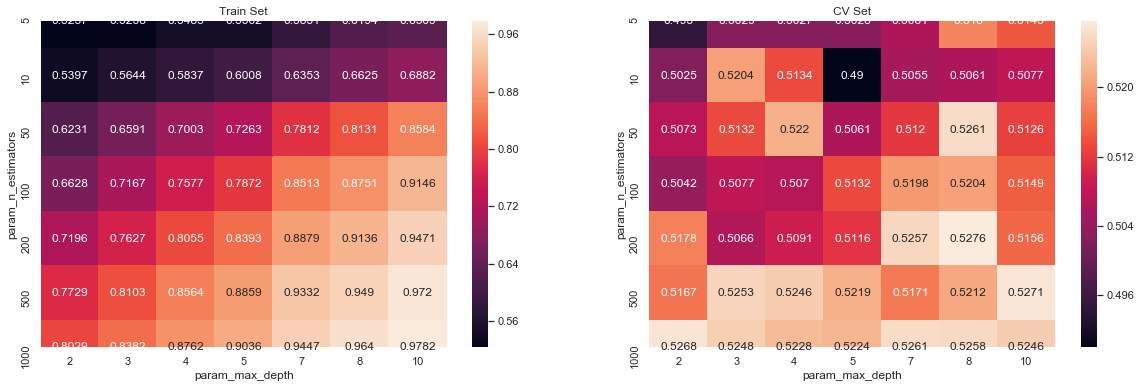

In [142]:
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [143]:
#Best Estimator and Best tune parameters
print(clf1.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf1.score(X_train_bow,y_train))
print(clf1.score(X_test_bow,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.8759916608546918
0.515977026922592


In [144]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [1000], 'max_depth':[10]}]

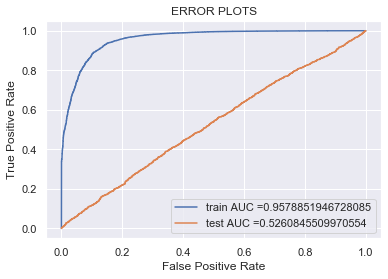

In [145]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_train_bow, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_bow) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_bow) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [146]:
#Confusion Matrix

def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.8 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.27 for threshold 0.51


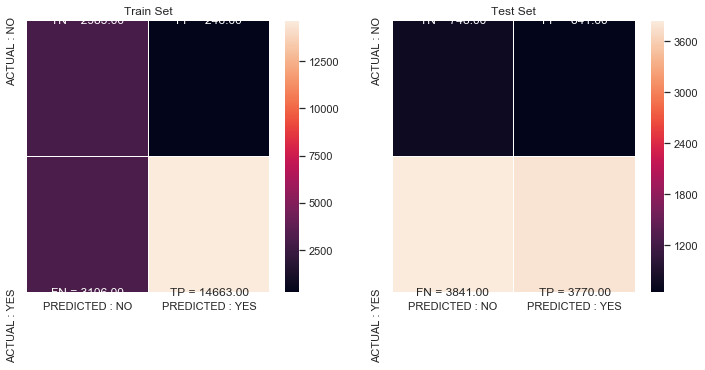

In [147]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## Random Forest on TFIDF data

In [148]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_tfidf = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train))
X_train_tfidf = hstack((X_train_bow, title_train_tfidf, text_train_tfidf))

X_test_tfidf =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test))
X_test_tfidf = hstack((X_test_bow,title_test_tfidf, text_test_tfidf))

In [149]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(21000, 22711)
(9000, 22711)


In [150]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt2 = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf2 = GridSearchCV(dt2, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se2 = clf2.fit(X_train_tfidf, y_train)

Text(0.5, 1, 'CV Set')

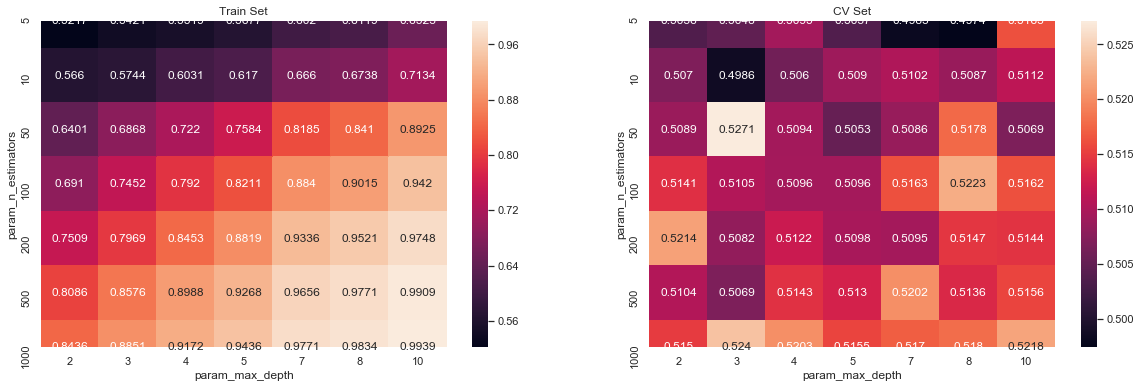

In [151]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf2.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

In [152]:
#Best Estimator and Best tune parameters
print(clf2.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf2.score(X_train_tfidf,y_train))
print(clf2.score(X_test_tfidf,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.6498925069879993
0.5256182106929278


In [153]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [500], 'max_depth':[10]}]

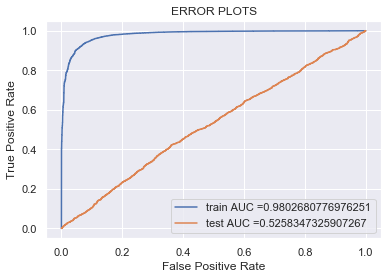

In [154]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_train_tfidf, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_tfidf) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_tfidf) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.87 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.28 for threshold 0.51


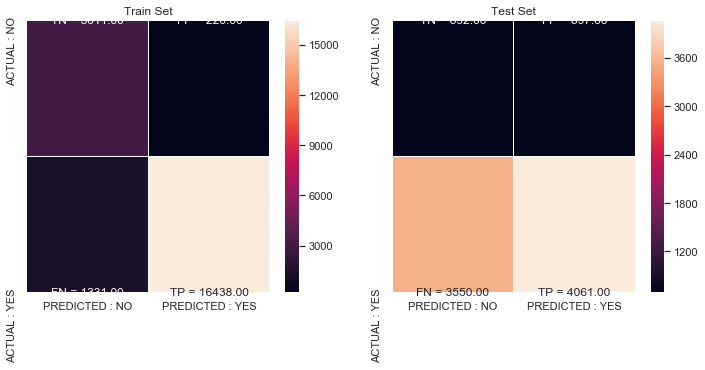

In [155]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## Random Forest Model on W2V data

In [156]:
a1 = np.array(avg_w2v_text_train)
a2 = np.array(avg_w2v_text_test)
b1 = np.array(avg_w2v_title_train)
b2 = np.array(avg_w2v_title_test)

In [157]:
a1.shape, a2.shape, b1.shape, b2.shape

((21000, 300), (9000, 300), (21000, 300), (9000, 300))

In [158]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_w2v = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train, a1, b1))
X_test_w2v =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test, a2, b2))

In [159]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt3 = RandomForestClassifier(class_weight='balanced',min_samples_split=3)
parameters ={'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf3 = GridSearchCV(dt3, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se3= clf3.fit(X_train_w2v, y_train)

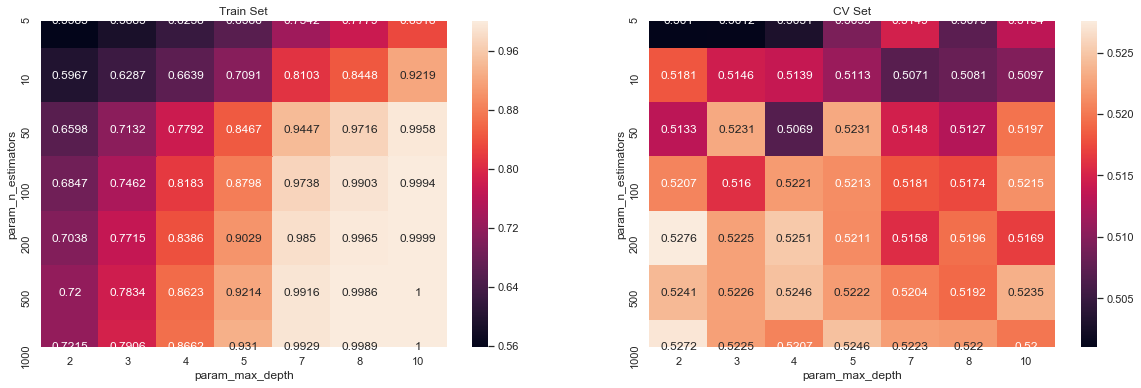

In [160]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf3.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [161]:
#*Best Estimator and best tune parameteR
print(clf3.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf3.score(X_train_w2v,y_train))
print(clf3.score(X_test_w2v,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.682967873465518
0.5321037462450383


In [162]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [1000], 'max_depth':[8]}]

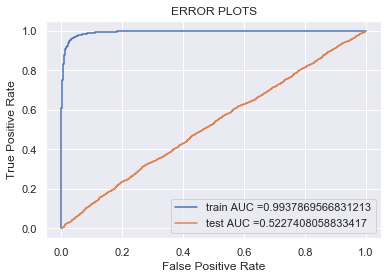

In [163]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_train_w2v, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_w2v) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_w2v) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.93 for threshold 0.51
the maximum value of tpr*(1-fpr) 0.27 for threshold 0.54


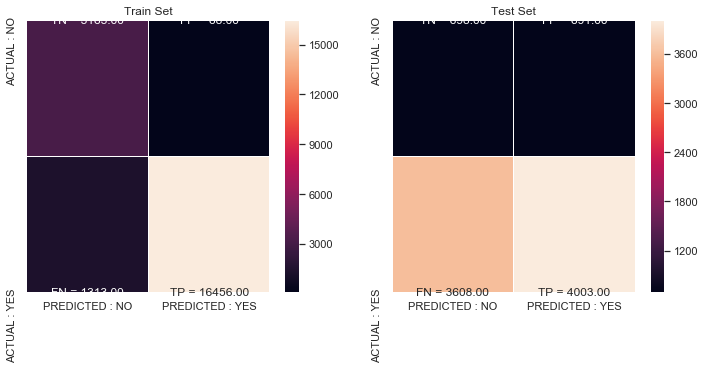

In [164]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

In [165]:
# print("Test confusion matrix")
# print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

In [166]:
# print("Test data confusion matrix")

# confusion_matrix_df_test = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
# sns.set(font_scale=1.4)#for label size
# sns.heatmap(confusion_matrix_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

## Random Forest Model on TF-IDF W2V Data

In [167]:
a1 = np.array(tfidf_w2v_train_text)
a2 = np.array(tfidf_w2v_train_title)
b1 = np.array(tfidf_w2v_test_text)
b2 = np.array(tfidf_w2v_test_title)

In [168]:
b1.shape

(9000, 300)

In [169]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_tfidf_w2v = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train, a1, a2))
X_test_tfidf_w2v =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test, b1, b2))

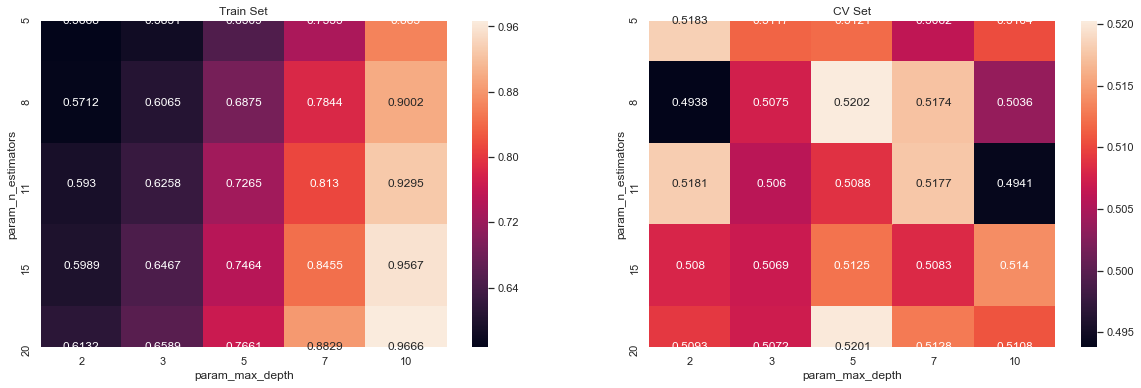

In [170]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

dt4 = RandomForestClassifier(class_weight='balanced',min_samples_split=3)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf4 = GridSearchCV(dt4, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se4 = clf4.fit(X_train_tfidf_w2v, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf4.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [171]:
#Best Estimator Best tune parameters
print(clf4.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf4.score(X_train_tfidf_w2v,y_train))
print(clf4.score(X_test_tfidf_w2v,y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=8, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.6654110153517826
0.5131707555630473


In [172]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[7] } ]

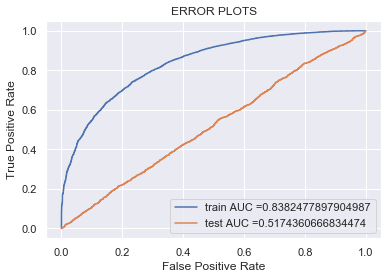

In [173]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 =GridSearchCV(RandomForestClassifier(class_weight='balanced',min_samples_split=3),best_tune_parameters)
clf11.fit(X_train_tfidf_w2v, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_tfidf_w2v) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_tfidf_w2v) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.57 for threshold 0.51
the maximum value of tpr*(1-fpr) 0.27 for threshold 0.53


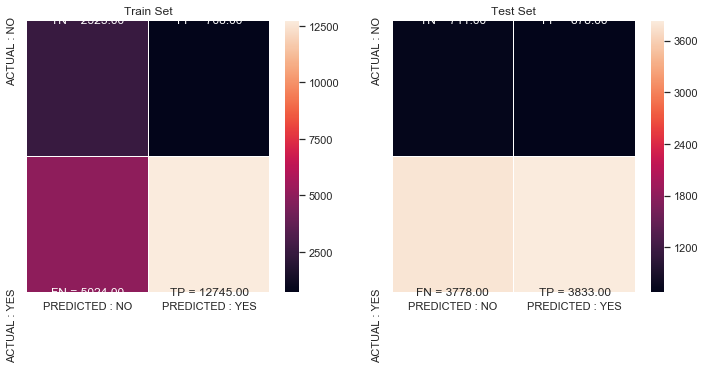

In [174]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## GBDT on BOW

In [175]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_bow = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train))
X_train_bow = hstack((X_train_bow, title_train_bow, text_train_bow))

X_test_bow =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test))
X_test_bow = hstack((X_test_bow,title_test_bow, text_test_bow))

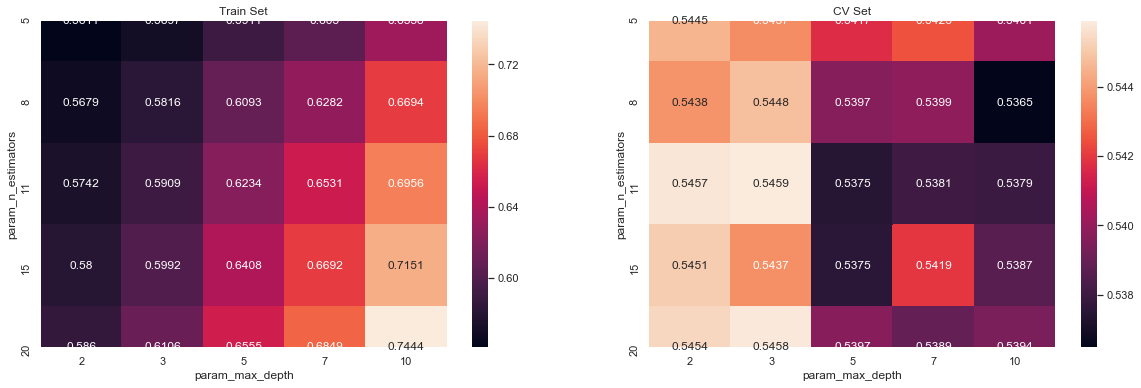

In [176]:
# from scipy.stats import randint as sp_randint
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier

# gbdt = XGBClassifier()

# grid_params = {'n_estimators': [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
 
# gs = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',n_jobs=-1)
# gs.fit(X_train_bow, y_train)

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
dt5 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10]}
clf5 = GridSearchCV(dt5, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se5 = clf5.fit(X_train_bow, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf5.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [177]:
#Best parameter
print(clf5.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf5.score(X_train_bow,y_train))
print(clf5.score(X_test_bow,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=11,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.5777230989695312
0.5453661617988969


In [178]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

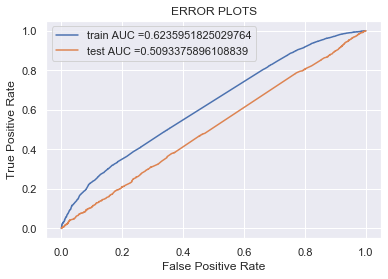

In [179]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_train_bow, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_bow) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_bow) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

## GBDT on TFIDF Data

In [180]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_tfidf = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train))
X_train_tfidf = hstack((X_train_tfidf, title_train_tfidf, text_train_tfidf))

X_test_tfidf =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test))
X_test_tfidf = hstack((X_test_tfidf,title_test_tfidf, text_test_tfidf))

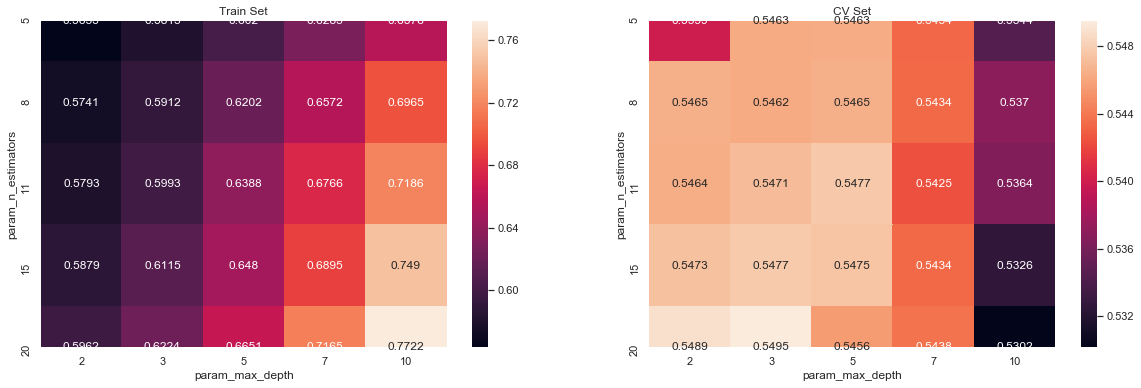

In [181]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt6 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf6 = GridSearchCV(dt6, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se6 = clf6.fit(X_train_tfidf, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf6.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [182]:
#Best estimator
print(clf6.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf6.score(X_train_tfidf,y_train))
print(clf6.score(X_test_tfidf,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.6124215683861595
0.5459941131394549


In [183]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

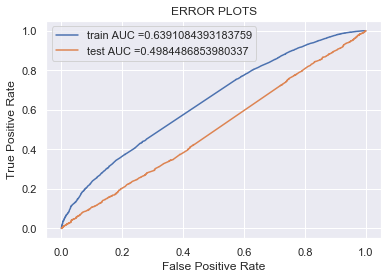

In [184]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_train_tfidf, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_tfidf) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_tfidf) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.33 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.24 for threshold 0.5


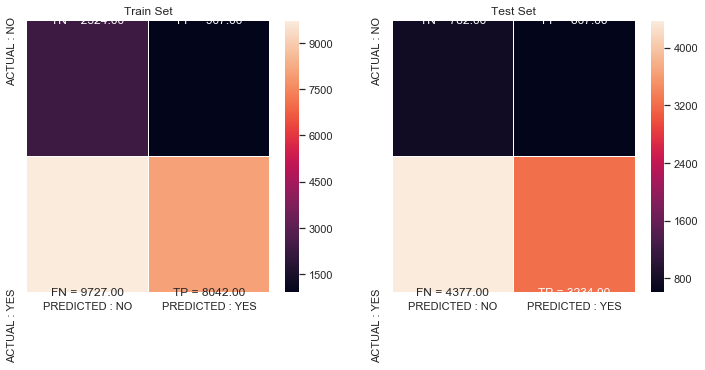

In [185]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## GBDT on W2V data

In [186]:
a1 = np.array(avg_w2v_text_train)
a2 = np.array(avg_w2v_text_test)
b1 = np.array(avg_w2v_title_train)
b2 = np.array(avg_w2v_title_test)

In [187]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_w2v = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train, a1, b1))
X_test_w2v =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test, a2, b2))

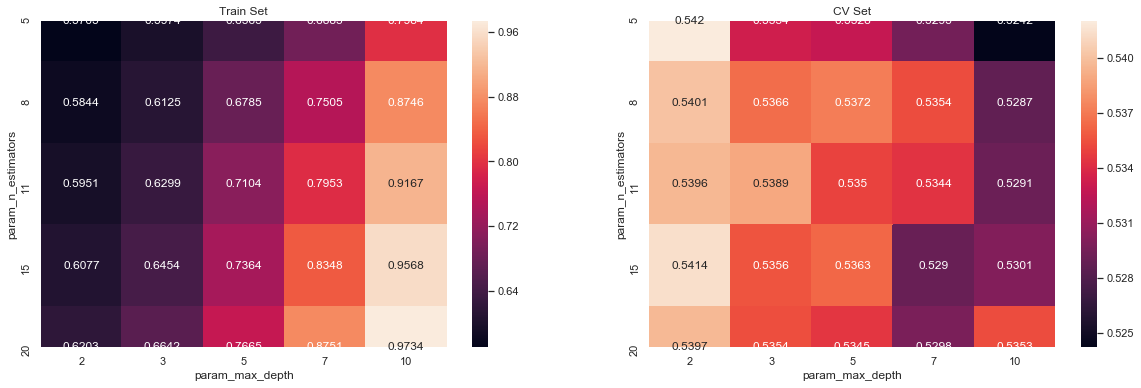

In [188]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

dt7 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf7 = GridSearchCV(dt7, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se7 = clf7.fit(X_train_w2v, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf7.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [189]:
#Best estimator
print(clf7.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf7.score(X_train_w2v,y_train))
print(clf7.score(X_test_w2v,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.5619587954978955
0.5378006653436981


In [190]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5]}]

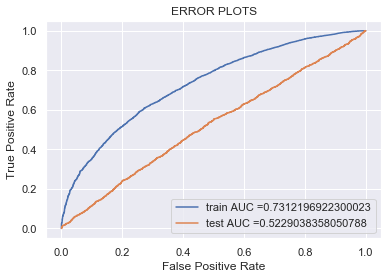

In [191]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_train_w2v, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_w2v) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_w2v) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.44 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.28 for threshold 0.51


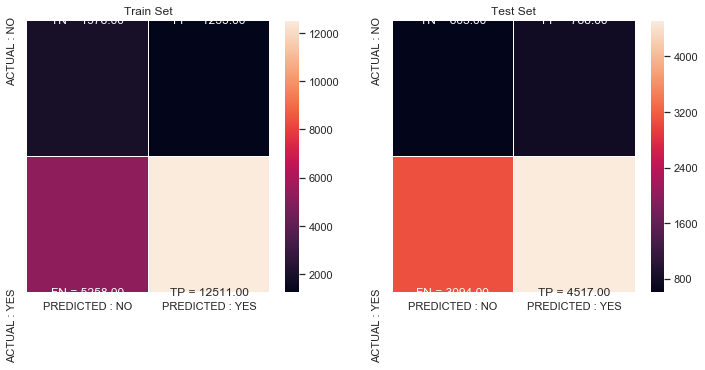

In [192]:
#Confusion matrix
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## GBDT on TFIDF-W2V data

In [193]:
a1 = np.array(tfidf_w2v_train_text)
a2 = np.array(tfidf_w2v_train_title)
b1 = np.array(tfidf_w2v_test_text)
b2 = np.array(tfidf_w2v_test_title)

In [194]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_w2v = np.hstack((cat_0_train_normalized, cat_1_train_normalized, subcat_0_train_normalized, subcat_1_train_normalized, state_0_train_normalized, state_1_train_normalized, grade_0_train_normalized, grade_1_train_normalized, prefix_0_train_normalized, prefix_1_train_normalized, price_standardized_train, quantity_standardized_train, prev_projects_standardized_train, a1, a2))
X_test_w2v =  np.hstack((cat_0_test_normalized, cat_1_test_normalized, subcat_0_test_normalized, subcat_1_test_normalized, state_0_test_normalized, state_1_test_normalized, grade_0_test_normalized, grade_1_test_normalized, prefix_0_test_normalized, prefix_1_test_normalized, price_standardized_test, quantity_standardized_test, prev_projects_standardized_test, b1, b2))

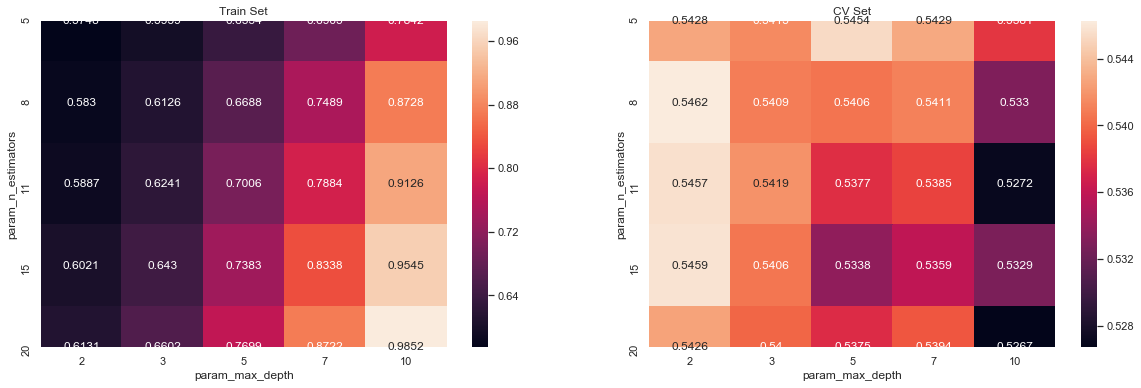

In [195]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt8 = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
clf8 = GridSearchCV(dt8, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se8 = clf8.fit(X_train_tfidf_w2v, y_train)
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf8.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [196]:
print(clf8.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf8.score(X_train_tfidf_w2v,y_train))
print(clf8.score(X_test_tfidf_w2v,y_test))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=8,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.5608987578285303
0.5405284250496066


In [197]:
# Best tune parameters
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

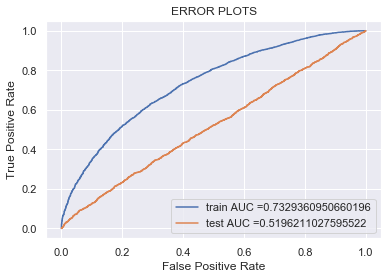

In [198]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
clf11.fit(X_train_tfidf_w2v, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_train_tfidf_w2v) [:,1]
y_test_pred1 = clf11.predict_proba(X_test_tfidf_w2v) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.45 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.26 for threshold 0.5


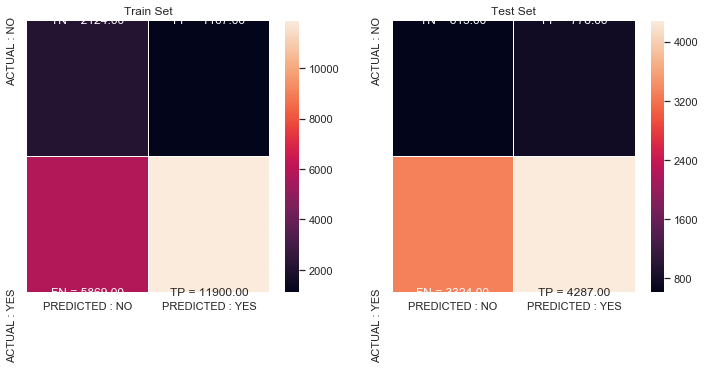

In [199]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5))

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

In [200]:
# Please compare all your models using Prettytable library
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Model ", " Vectorizer ", " n_estimators", " max_depth "," Test -AUC ")
tb.add_row([ "Random Forest", " BOW ", 1000,10, 71.8 ])
tb.add_row([ "Random Forest", " Tf - Idf", 500 , 10 , 71.3 ])
tb.add_row([ "Random Forest", " AVG-W2V", 1000, 8 , 70.6 ])
tb.add_row([ "Random Forest", " A VG - Tf - Idf",20 , 7 , 68.2 ])
tb.add_row([ "Gradient Boosting DT", " Bow ",20 , 5 , 67.7 ])
tb.add_row([ "Gradient Boosting DT", " Tf - Idf",20 , 5 , 66.2 ])
tb.add_row([ "Gradient Boosting DT", " AVG-W2V", 20 , 5 , 68.6])
tb.add_row([ "Gradient Boosting DT", "A VG - Tf - Idf", 20 , 5 , 68.1 ])
print(tb.get_string(titles = "Random Forest and GBDT- Observations"))

+----------------------+------------------+---------------+-------------+-------------+
|        Model         |    Vectorizer    |  n_estimators |  max_depth  |  Test -AUC  |
+----------------------+------------------+---------------+-------------+-------------+
|    Random Forest     |       BOW        |      1000     |      10     |     71.8    |
|    Random Forest     |     Tf - Idf     |      500      |      10     |     71.3    |
|    Random Forest     |      AVG-W2V     |      1000     |      8      |     70.6    |
|    Random Forest     |  A VG - Tf - Idf |       20      |      7      |     68.2    |
| Gradient Boosting DT |       Bow        |       20      |      5      |     67.7    |
| Gradient Boosting DT |     Tf - Idf     |       20      |      5      |     66.2    |
| Gradient Boosting DT |      AVG-W2V     |       20      |      5      |     68.6    |
| Gradient Boosting DT | A VG - Tf - Idf  |       20      |      5      |     68.1    |
+----------------------+--------